In [1]:
# Load text files
def loadFile(name):
    with open(name, 'r', encoding='iso-8859-2') as f:
        return [x.rstrip('\n') for x in f.readlines()]

textcz = loadFile('TEXTCZ1.txt')
texten = loadFile('TEXTEN1.txt')

In [2]:
# Generate n-grams and compute frequencies
import collections

def generateNgrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ngrams

def frequency(ngram):
    return collections.Counter(ngram)   

def distribution(ngram):
    freq = frequency(ngram)
    total = float(sum(freq.values()))
    return {k:v/total for (k,v) in freq.items()}

In [3]:
# Compute entropies
import math

def condEntropy(tokens):
    gram1, gram2 = list(generateNgrams(tokens, 1)), list(generateNgrams(tokens, 2))
    dist1, dist2 = distribution(gram1), distribution(gram2)
    freq1, freq2 = frequency(gram1), frequency(gram2)
    total = 0.0
    for (i,j) in set(gram2):
        if dist1[(i,)] != 0 and dist2[(i,j)] != 0:
            p = freq2[(i,j)]/freq1[(i,)]
            total -= dist2[(i,j)] * math.log(p, 2)
    return total

def simpleEntropy(tokens):
    gram1 = list(generateNgrams(tokens, 1))
    dist1 = distribution(gram1)
    total = 0.0
    for i in set(gram1):
        if dist1[i] != 0:
            total -= dist1[i]*math.log(dist1[i], 2)
    return total

In [4]:
# Define the mess functions
import random

def messChar(tokens, prob=0.0):
    alphabet = list(set(''.join(tokens)))
    tokens2 = list(tokens)
    for i in range(len(tokens2)):
        for j in range(len(tokens2[i])):
            if random.random() < prob:
                # the character can be replaced by itself
                new = list(tokens2[i])
                new[j] = random.choice(alphabet)
                tokens2[i] = ''.join(new)
    return tokens2

def messWord(tokens, prob=0.0):
    alphabet = list(set(tokens))
    tokens2 = list(tokens)
    for i in range(len(tokens2)):
        if random.random() < prob:
            # the word can be replaced by itself
            tokens2[i] = random.choice(alphabet)
    return tokens2

In [5]:
# Run the first experiment
from IPython.display import display
import pandas as pd

PROBS = [0, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, .2, .3, .4, .5]
def experiment1(tokens, messFun, repeat=1):
    out = []
    for probI in range(len(PROBS)):
        random.seed(0)
        entropies = []
        for i in range(repeat):
            tokensModified = messFun(tokens, PROBS[probI])
            entropies.append(condEntropy(tokensModified))
        out.append((probI, PROBS[probI], sum(entropies)/len(entropies), min(entropies), max(entropies)))
    print('-')
    return pd.DataFrame(data=out, columns=['index', 'prob', 'avg', 'min', 'max'])

expCzChar = experiment1(textcz, messChar)
expCzWord = experiment1(textcz, messWord)
expEnChar = experiment1(texten, messChar)
expEnWord = experiment1(texten, messWord)

-
-
-
-


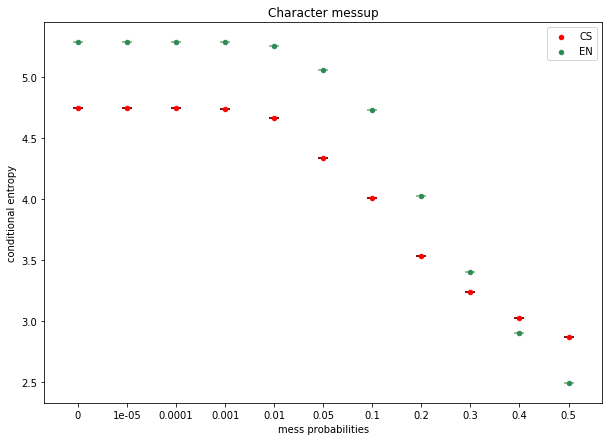

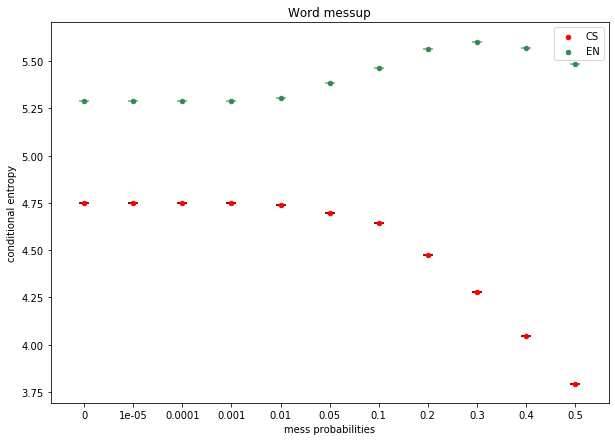

In [15]:
# Plot the relevant graphs for experiment 1
import matplotlib.pyplot as plt

def plotEx1(exps, cols, labels, title=''):
    ax = plt.gca()
    plt.xticks(range(len(PROBS)), PROBS)
    for (exp,col,lab) in zip(exps, cols, labels):
        exp.plot(kind='scatter', color='Dark'+col, marker="_", s=100, y='min', x='index', ax=ax)
        exp.plot(kind='scatter', color='Dark'+col, marker="_", s=100, y='max', x='index', ax=ax)
        exp.plot(kind='scatter', color=col, y='avg', x='index', ax=ax, label=lab, figsize=(10,7))
    plt.xlabel('mess probabilities'), plt.ylabel('conditional entropy')
    plt.title(title), plt.show()

plotEx1([expCzChar, expEnChar], ['Red', 'Seagreen'], ['CS', 'EN'], "Character messup")
plotEx1([expCzWord, expEnWord], ['Red', 'Seagreen'], ['CS', 'EN'], "Word messup")

The tables Character messup and Word messup describe the relationship between the messup probability for characters and words respectively and conditional entropy of the resulting text. All of the mentioned phenomena are explained in detail after the next table and graphs are introduced.

### Character messup
The conditional entropy for character messup is decreasing for both Czech and English. The initial conditional entropy for English is higher than the one for Czech. The conditional entropy is also decreasing faster for the former language.

### Word messup
The conditional entropy for word messup is first increasing for English, but then it starts to decrease around `p = 0.5`. The conditional entropy for Czech is lower than for English and is decreasing already from the beginning.

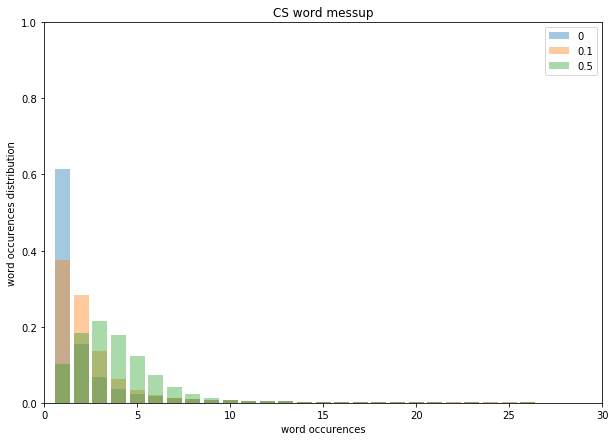

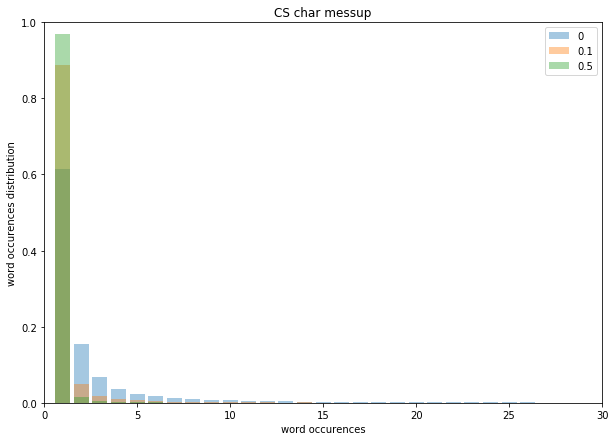

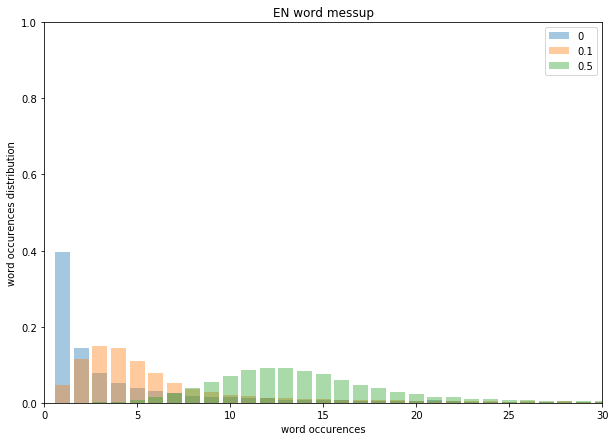

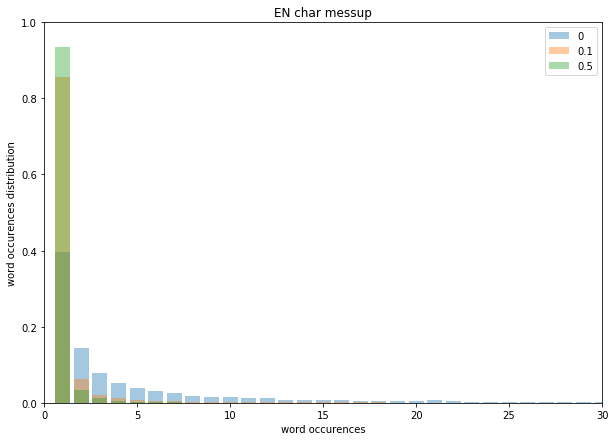

In [7]:
# Plot bucket distribution
def plotWordOccurence(tokens, messFunc, title):
    f, ax = plt.subplots(figsize=(10,7)) 
    for prob in [0, 0.1, 0.5]:
        D = distribution(frequency(messFunc(tokens, prob)).values())
        Ds = collections.OrderedDict(sorted(D.items()))
        plt.bar(list(Ds.keys()), list(Ds.values()), alpha=0.4, label=prob)
        plt.legend()
    plt.xlabel("word occurences"), plt.ylabel("word occurences distribution")
    plt.ylim(0, 1), plt.xlim(0, 30)
    plt.title(title), plt.show()

plotWordOccurence(textcz, messWord, 'CS word messup')
plotWordOccurence(textcz, messChar, 'CS char messup')
plotWordOccurence(texten, messWord, 'EN word messup')
plotWordOccurence(texten, messChar, 'EN char messup')

In [8]:
# Tabulate language statistics
from tabulate import tabulate
def calcStat(lang, tokens):
    alphabet = set(''.join(tokens))
    wordLengths = [len(x) for x in tokens]
    bigrams = generateNgrams(tokens, 2)
    return [lang, len(alphabet), sum(wordLengths)/float(len(wordLengths)), len(set(tokens)), len(set(bigrams))]

statCS = calcStat('CS', textcz)
statEN = calcStat('EN', texten)

stats = pd.DataFrame(data=[statCS, statEN], columns=['language', 'unique characters', 'avg word length', 'unique words', 'unique bigrams'])
stats.round(2)

,language,unique characters,avg word length,unique words,unique bigrams
0,CS,117,4.63,42826,147136
1,EN,74,4.40,9607,73246


### Word occurences distribution tables
The previous four graphs (CS/EN word/char messup) display multiple histograms with respect to the messup probabilities. The histograms are distributions of word occurences. The __x__ axis determines the number of occurences and the __y__ axis the distribution of such words. There are always three semitransparent histograms in one graph for messup probabilities __0, 0.1__ and __0.5__.

### Initial values
The initial conditional entropy of English is higher than for Czech. We attribute this to the lower number of words that appear only once (singletons) in English, as is apparent from the the EN char/word messup histograms (leftmost bars). Singletons do not contribute to the entropy, becasue `log(p(x|y)/p(y)) = log(p(y)/p(y)) = 0`. 

### Character messup
The conditional entropy of English with character messup is decreasing faster, because more words get turned to singleton words, whilst in Czech many of the words were singletons already from the beginning.

### Word messup
The progression of conditional entropies for word messups is more variable. There are mainly two factors after creating a new bigram, that affect the entropies:

1. Increasing entropy: new random bigram already exists in the text
2. Decreasing entropy: new random bigram is unique

For Czech, the first factor is insignificant from the beginnig, as there are many unique bigrams and much more unique words than in English (see the above table). For Czech the second factor is higher because of the same reasons.

Since English has lower number of unique words, the chance of creating a unique bigram is initially low. As the messup probability increases, the words are becomming to be distributed uniformly. This results in histograms with normal-like curves. With more uniform distribution, more random words start to appear next to each other and due to the initially lower number of unique bigrams, the second factor starts getting more significant.



We start by computing the conditional entropy for bigrams for the new text. The formula is split into three parts: bigrams solely in $T_1$, bigrams solely in $T_2$ and the one unique bigram in the middle.

$$
\alpha = \text{last element of } T_1, \omega = \text{first element of } T_2
$$

$$
H_{12} =
- \sum_{(i,j) \in T_1} \frac{\text{bigrams in } T_1}{\text{bigrams in } T_12} p_1(i,j) \log(p_1(j|i))
- \sum_{(i,j) \in T_2} \frac{\text{bigrams in } T_1}{\text{bigrams in } T_12} p_2(i,j) \log(p_2(j|i))
- p_{12}(\omega, \alpha) \log(p_{12}(\omega|\alpha)) \\
H_{12} =
- \sum_{(i,j) \in T_1} \frac{|T_1|-1}{|T_1| + |T_2|-1} p_1(i,j) \log(p_1(j|i))
- \sum_{(i,j) \in T_2} \frac{|T_2|-1}{|T_1| + |T_2|-1} p_2(i,j) \log(p_2(j|i))
- p_{12}(\omega, \alpha) \log(p_{12}(\omega|\alpha)) \\
H_{12} =
- \sum_{(i,j) \in T_1} \frac{|T_1|-1}{|T_1| + |T_2|-1} p_1(i,j) \log(p_1(j|i))
- \sum_{(i,j) \in T_2} \frac{|T_2|-1}{|T_1| + |T_2|-1} p_2(i,j) \log(p_2(j|i))
- \frac{1}{|T_1| + |T_2|-1} \log(1/\# \alpha) \\
H_{12} =
  \frac{|T_1|-1}{|T_1| + |T_2|-1} E_1
+ \frac{|T_2|-1}{|T_1| + |T_2|-1} E_2
- \frac{1}{|T_1| + |T_2|-1} \log(1/\# \alpha) \\
H_{12} =
\frac{|T_1| E + |T_2|  E -2E - \log(1/\# \alpha)}{|T_1| + |T_2|-1}
$$

Now we want to see how this expression compares to $E$:

$$
\frac{|T_1| E + |T_2|  E -2E - \log(1/\# \alpha)}{|T_1| + |T_2|-1} <> E \\
|T_1| E + |T_2|  E -2E - \log(1/\# \alpha) <> E |T_1| + E|T_2|-E \\
-\log(1/\# \alpha) <> E \\
\log(\# \alpha) <> E \\
\# \alpha <> 2^E = \text{perp.} \\
$$

This means, that the new conditional entropy for bigrams is higher iff the number of occurences is greater than the perplexity (from conditional entropy for bigrams for any of the initial texts). It is not very intuitive as to why the expected number of bits needed to encode a word should be compared with the number of occurences of the last word from the first text. Because of this, we demonstrate it on several inputs.

(I discussed this part extensively with my classmate Ondřej Měkota.)

In [9]:
countLast = lambda x: x.count(x[-1])
perplexity = lambda toks: math.pow(2, condEntropy(toks))

def thHypothesis(textr1):
    textr1 = list(textr1)
    # we create uppercase version of the first text
    textr2 = [x.upper() for x in textr1]   
    print(f'text: {"".join(textr1)}{"".join(textr2)}')
    print(f'count alpha: {countLast(textr1):5.2f}')
    print(f'perplexity:  {perplexity(textr1):5.2f}')
    if countLast(textr1) > perplexity(textr1):
        print('Hypothesis: condE12 > condE1 = condE2')
    elif countLast(textr1) < perplexity(textr1):
        print('Hypothesis: condE12 < condE1 = condE2')
    else:
        print('Hypothesis: condE12 = condE1 = condE2')
    print(f'condE1:  {condEntropy(textr1):5.2f}')
    print(f'condE1:  {condEntropy(textr1):5.2f}')
    print(f'condE12: {condEntropy(textr1+textr2):5.2f}\n')
    
thHypothesis('aaabbb')
thHypothesis('addadb')
thHypothesis('adacdc')

text: aaabbbAAABBB
count alpha:  3.00
perplexity:   1.72
Hypothesis: condE12 > condE1 = condE2
condE1:   0.78
condE1:   0.78
condE12:  0.86

text: addadbADDADB
count alpha:  1.00
perplexity:   1.93
Hypothesis: condE12 < condE1 = condE2
condE1:   0.95
condE1:   0.95
condE12:  0.86

text: adacdcADACDC
count alpha:  2.00
perplexity:   2.00
Hypothesis: condE12 = condE1 = condE2
condE1:   1.00
condE1:   1.00
condE12:  1.00



In [10]:
def splitData(tokens):
    # training, heldoout, test data
    return (tokens[:len(tokens)-60000], tokens[-20000:][-40000:], tokens[-20000:])

In [11]:
TOK_S = '<S>'
TOK_SS = [TOK_S]*2

# Training, Heldout and Test
def splitData(data):
    return (
        TOK_SS + data[:len(data)-60000], \
        TOK_SS + data[-60000:][:40000], \
        TOK_SS + data[-20000:]
    )

# Divide a by b if b is nonzero, otherwise return zero
def divNonZero(a, b):
    return a/b if b != 0 else 0

# Uniform, unigram, bigram and trigram probabilities
GRAM_PROBS = [
    lambda dataFreq, toks: 1/len(dataFreq['vocab']),
    lambda dataFreq, toks: dataFreq['unigram'][(toks[2],)]/len(dataFreq['data']),
    lambda dataFreq, toks: divNonZero(dataFreq['bigram'][(toks[1], toks[2])], dataFreq['unigram'][(toks[1],)]),
    lambda dataFreq, toks: divNonZero(dataFreq['trigram'][(toks[0], toks[1], toks[2])], dataFreq['bigram'][(toks[0], toks[1])]),
]

# Compute smoothed probabilities
def smoothProb(lambdas, dataFreq, toks):
    return sum([lambdas[i] * GRAM_PROBS[i](dataFreq, toks) for i in range(4)])

# Compute expected counts for lambdas
def expectedCounts(lambdas, index, dataFreqTrain, dataFreqHeldout):
    total = 0
    tokens = dataFreqHeldout['data']
    for i in range(2, len(tokens)):
        total += \
            GRAM_PROBS[index](dataFreqTrain, (tokens[i-2], tokens[i-1], tokens[i])) / \
            smoothProb(lambdas, dataFreqTrain, (tokens[i-2], tokens[i-1], tokens[i]))
    return lambdas[index]*total

# Compute next lambdas
def recomputeLambdas(lambdas, dataFreqTrain, dataFreqHeldout):
    counts = [expectedCounts(lambdas, i, dataFreqTrain, dataFreqHeldout) for i in range(4)]
    return [c/sum(counts) for c in counts]

# Format lambdas nicely
formatLambdas = lambda x: " ".join([f"{l:5.3f}" for l in x])

# Generates frequencies used for probabilities
def generateDataFreq(data):
    return {
        'vocab': set(data),
        'data': data,
        'unigram': frequency(generateNgrams(data, 1)),
        'bigram' : frequency(generateNgrams(data, 2)),
        'trigram': frequency(generateNgrams(data, 3)),
    }

# EM smoothing algorithm
def emAlg(dataTrain, dataHeldout):
    lambdas = [0.25, 0.25, 0.25, 0.25]
    dataFreqTrain = generateDataFreq(dataTrain)
    dataFreqHeldout = generateDataFreq(dataHeldout)
    diff = 1
    i = 0
    while diff > 0.0001:
        i += 1
        lambdasNext = recomputeLambdas(lambdas, dataFreqTrain, dataFreqHeldout)
        diff = sum([abs(x[0]-x[1]) for x in zip(lambdasNext, lambdas)])
        #  print(f'i: {i:2}, diff: {diff:8.6f}, lambdas: {" ".join([f"{l:5.3f}" for l in lambdasNext])}')
        lambdas = lambdasNext
    return lambdas

dataEnTr, dataEnHe, dataEnTe = splitData(texten)
dataCsTr, dataCsHe, dataCsTe = splitData(textcz)

lambdasEnTrHe = emAlg(dataEnTr, dataEnHe)
print('Lambdas EN Train -> Heldout:', formatLambdas(lambdasEnTrHe))
lambdasEnTrTr = emAlg(dataEnTr, dataEnTr)
print('Lambdas EN Train -> Train:  ', formatLambdas(lambdasEnTrTr))
lambdasCsTrHe = emAlg(dataCsTr, dataCsHe)
print('Lambdas CS Train -> Heldout:', formatLambdas(lambdasCsTrHe))
lambdasCsTrTr = emAlg(dataCsTr, dataCsTr)
print('Lambdas CS Train -> Train:  ', formatLambdas(lambdasCsTrTr))

Lambdas EN Train -> Heldout: 0.098 0.264 0.508 0.130
Lambdas EN Train -> Train:   0.000 0.000 0.000 1.000
Lambdas CS Train -> Heldout: 0.253 0.443 0.243 0.061
Lambdas CS Train -> Train:   0.000 0.000 0.000 1.000


In [16]:
import matplotlib.pyplot as plt

# Cross-entropy
def crossEntropySmoothed(dataFreq1, lambdas, dataFreq2):
    total = 0
    tokens = dataFreq1['data']
    trigrams2 = dataFreq2['trigram']
    for i in range(2, len(tokens)):
        trigram = (tokens[i-2], tokens[i-1], tokens[i])
        prob2 = smoothProb(lambdas, dataFreq2, trigram)
        total -= math.log(prob2, 2) if prob2 != 0 else 0
    return total/len(tokens)

crossEntropyCsHe = crossEntropySmoothed(generateDataFreq(dataCsTe), lambdasCsTrHe, generateDataFreq(dataCsTr))
crossEntropyCsTr = crossEntropySmoothed(generateDataFreq(dataCsTe), lambdasCsTrTr, generateDataFreq(dataCsTr))
crossEntropyEnHe = crossEntropySmoothed(generateDataFreq(dataEnTe), lambdasEnTrHe, generateDataFreq(dataEnTr))
crossEntropyEnTr = crossEntropySmoothed(generateDataFreq(dataEnTe), lambdasEnTrTr, generateDataFreq(dataEnTr))

print(f'CS Heldout Cross Entropy: {crossEntropyCsHe:5.2f}')
print(f'CS Train   Cross Entropy: {crossEntropyCsTr:5.2f}')
print(f'EN Heldout Cross Entropy: {crossEntropyEnHe:5.2f}')
print(f'En Train   Cross Entropy: {crossEntropyEnTr:5.2f}')

CS Heldout Cross Entropy: 10.39
CS Train   Cross Entropy: 53.16
EN Heldout Cross Entropy:  7.56
En Train   Cross Entropy: 25.52


When training lambdas on the training data, we see that the highest weight is always on $l_3$. This is obvious, as we can minimize the entropy by using ngrams with maximum n and thus overfitting.

For both languages, the cross-entropy for lambdas trained on the training data is absurdly high compared to the cross-entropy for lambdas trained on the heldout data. This is because the cross-entropy is the number of bits needed for encoding a word in one distribution, given that we use a system optimized for the second distribution. Since in this case, we overfitted the lambdas on the training data, the system will be less optimal for the rest of the language (represented by the test data) and we would thus need a higher number of bits.

Discussion on the relative entropy is in the last section, accompanied by more data.

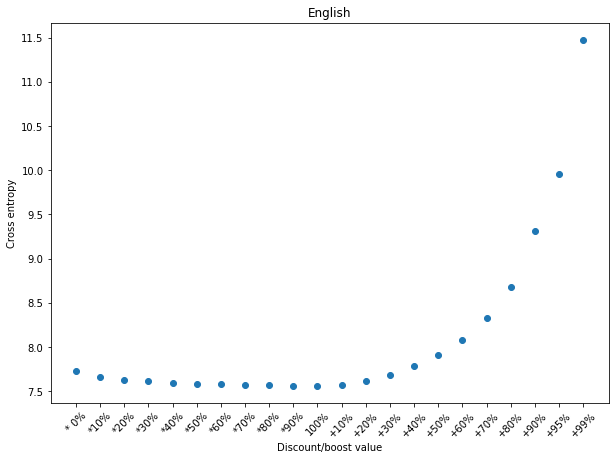

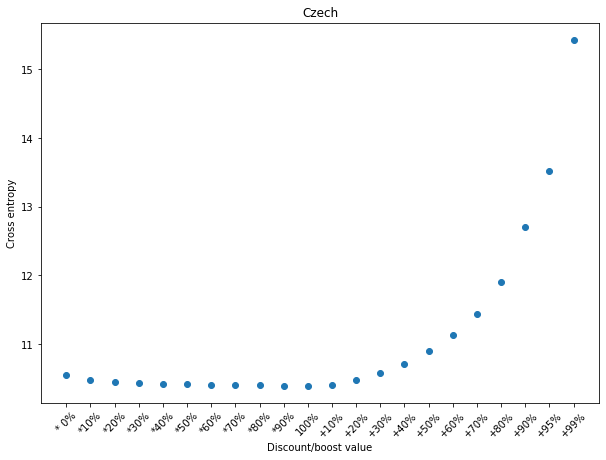

In [17]:

def plotEx2(data, lambdasOrig, title=''):
    dataTr, dataHe, dataTe = splitData(data)
    lambdasToTest = []
    MUL_VALS = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    BOOST_VALS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    
    # Normalizes first three values so that all four of them add up to 1
    def normalizeRest(lambdas):
        target_sum = 1 - lambdas[3]
        rest_sum = sum(lambdas[:3])
        for i in [0,1,2]:
            lambdas[i] = lambdas[i]/rest_sum * target_sum
        assert(abs(sum(lambdas)-1)<0.001)
        return lambdas
    
    # Discount the last lamdba
    for mul in MUL_VALS:
        lambdas = list(lambdasOrig) # deep copy
        lambdas[3] *= mul
        normalizeRest(lambdas)
        lambdasToTest.append(lambdas)
        
    # Original
    lambdasToTest.append(lambdasOrig)
    
    # Boost the last lambda
    for boost in BOOST_VALS:
        lambdas = list(lambdasOrig) # deep copy
        lambdas[3] += (1-lambdas[3])*boost
        normalizeRest(lambdas)
        lambdasToTest.append(lambdas)
    
    dataFreqTe = generateDataFreq(dataTe)
    dataFreqTr = generateDataFreq(dataTr)
    out = [crossEntropySmoothed(dataFreqTe, lambdas, dataFreqTr) for lambdas in lambdasToTest]
    XLABELS = [f'*{x*100:2.0f}%' for x in MUL_VALS] + ['100%'] + [f'+{x*100:2.0f}%' for x in BOOST_VALS]
    
    plt.figure(figsize=(10, 7))
    plt.plot(range(len(out)), out, 'o')
    plt.xticks(range(len(out)), labels=XLABELS, rotation=45)
    plt.ylabel('Cross entropy'), plt.xlabel('Discount/boost value'), plt.title(title)
    
plotEx2(texten, lambdasEnTrHe, 'English')
plotEx2(textcz, lambdasCsTrHe, 'Czech')

In [14]:
import pandas as pd

# Coverage
def computeCoverage(data1, data2):
    unigrams = 0
    bigrams = 0
    trigrams = 0
    for x in data1['trigram'].keys():
        if x in data2['trigram'].keys():
            trigrams += data2['trigram'][x]
    for x in data1['bigram'].keys():
        if x in data2['bigram'].keys():
            bigrams += data2['bigram'][x]
    for x in data1['unigram'].keys():
        if x in data2['unigram'].keys():
            unigrams += data2['unigram'][x]
    trigrams /= sum(data2['trigram'].values())
    bigrams /= sum(data2['bigram'].values())
    unigrams /= sum(data2['unigram'].values())
    return [unigrams, bigrams, trigrams]

tmpCs = computeCoverage(generateDataFreq(dataCsTe), generateDataFreq(dataCsTr))
tmpEn = computeCoverage(generateDataFreq(dataEnTe), generateDataFreq(dataEnTr))

pd.DataFrame(
    data=[['EN'] + tmpEn, ['CS'] + tmpCs],
    columns=['Language', 'Unigrams', 'Bigrams', 'Trigrams'])

,Language,Unigrams,Bigrams,Trigrams
0,EN,0.894538,0.465621,0.140958
1,CS,0.664801,0.193710,0.054159


Since English has less unique words, there is a much bigger overlap between the training and the testing data. This allows the EM algorithm to put more weight on trigrams and bigrams, which can model the language with more detail. Because of this overlap, the final cross-entropy for English is lower than for Czech, because the model (lambdas) can describe it more accurately.

From the two previous graphs, we can see a trend, that the more we enforce the use of trigrams, the less effective our best possible encoding on unseen data becomes. This is consistent with the previous observation because enforcing the use of trigrams means overfitting on the training data.

On the left part of the graph we can observe, that by artificially diminishing the weight of the trigram probabilities, the cross-entropy also increases. This is obvious, as the EM algorithm tries to minimize the cross-entropy and if it could be further minimized by lowering the weight of trigram probabilities, it would have done so. 

The loss of optimality is not as drastic as in boosting the weight of the trigram probabilities. This may be because there are quite a lot of out of vocabulary tokens (and similarly for bigrams and trigrams), which can be handled only by zerogram, unigram and bigram probabilities respectively, which this discounting disregards.